# Test: free fall time in streamline model in comparison with the theoretical streamline model

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import numpy as np
import astropy.units as u
import velocity_tools.stream_lines as SL
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.constants import G
from NOEMAsetup import *
from astropy.coordinates import SkyCoord, FK5


5590.2755238702985 yr
5590.275523870298 yr


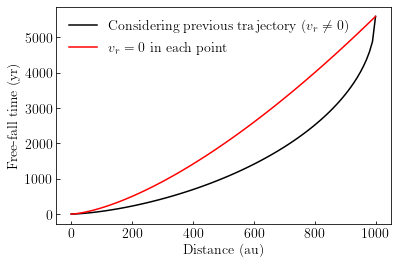

In [2]:
# Just if you are curious, this is how different the timescales look theoretically when considering continuous infalling motion
r0 = 1000 * u.au
rfin = np.arange(0, r0.value+10, 10) * u.au
t_ff_acc = t_freefall(r0, 1*u.Msun) - t_freefall_acc(rfin, r0, r0)
print(t_freefall_acc(0., r0, r0))
print(t_freefall(r0, 1*u.Msun))
plt.plot(rfin, t_ff_acc, 'k',label=r'Considering previous trajectory ($v_r\neq0$)')
plt.plot(rfin, t_freefall(rfin, 1*u.Msun),'r', label=r'$v_r=0$ in each point')
plt.xlabel('Distance (au)')
plt.ylabel('Free-fall time (yr)')
plt.legend(frameon=False)


First, we run a streamline model with little rotation for testing

In [3]:
# model parameters
M_s = 1.71*u.Msun # was 2.9
M_env = 0.39*u.Msun # upper limit
M_disk = 0.58*u.Msun
Mstar = (M_s+M_env+M_disk)
# Mstar = 1 * u.Msun

# Disk inclination system
inc = 0. * u.deg
PA_ang = 0. *u.deg

theta0 = 61.5 * u.deg  # rotate clockwise
phi0 = 28. * u.deg  # rotate the plane
v_r0 = 1.25 * u.km/u.s
r0 = 3300*u.au

omega0 = 4.53e-13 / u.s

# what happens if we incline it? seems that nothing, luckily
# inc = 30. * u.deg
# PA_ang = 10. *u.deg

# theta0 = 70 * u.deg  # rotate clockwise
# phi0 = 10. * u.deg  # rotate the plane
# v_r0 = 0. * u.km/u.s
# r0 = 1000 *u.au

# omega0 = 1e-14 / u.s

Then, we run our model.

From the model we need:
- the distance from the protostar to all points along the streamer 
- the magnitude of the velocity at each point
- The size of each segment along the streamer
- The time required to travel each segment
- The time to get from the protostar to that point along the streamer (cumulative sum from each segment)
- The theoretical free fall timescale in each point

In [4]:
(x1, y1, z1), (vx1, vy1, vz1) = SL.xyz_stream(mass=Mstar, r0=r0, theta0=theta0, phi0=phi0, omega=omega0, v_r0=v_r0, inc=inc, pa=PA_ang) #, deltar=10*u.au)

dist_streamer = np.sqrt(x1**2 + y1**2 + z1**2) # distance from protostar to point
dist_2d_streamer = np.sqrt(x1**2 + y1**2) # cilyndrical distance from protostar to point

# from the velocity we need to erase the first, and for the segments we need to erase the last
vel_streamer = np.sqrt(vx1**2 + vy1**2 + vz1**2) # total velocity at point x,y,z

# we calculate the size of each segment and the time to travel the streamer
dx1 = np.roll(x1, 1) - x1
dy1 = np.roll(y1, 1) - y1
dz1 = np.roll(z1, 1) - z1
# we need to unroll so that the segments match their velocities
deltas = np.sqrt(dx1**2 + dy1**2 + dz1**2)[2:]
vel_mean = 0.5*(np.roll(vel_streamer, 1) + vel_streamer)[2:]
dist_mean = 0.5*(np.roll(dist_streamer, 1) + dist_streamer)[2:]
dist_2d_mean = 0.5*(np.roll(dist_2d_streamer, 1) + dist_2d_streamer)[2:]
# The last value does not make sense because it is from the last to the first one of the list. 
deltat = (deltas / vel_mean).to(u.yr)
# usually we need to sacrifice the first two points: the first because of the roll and the second because of the initial v=0

# we reverse two times to sum from protostar to start point and return the array to its original order
# t0 = t_freefall(np.amin(dist_streamer.value)*u.au, Mstar) # There must be a time to fall from rmin to the protostar
time_integral_path = np.flip(np.cumsum(np.flip(deltat)))# + t0

rc=229.0772556557776 AU


In [5]:
time_theory = t_freefall_acc(0 *u.au, dist_mean, r0, mass=Mstar)


We plot the times together. For a model with no rotation and initial radial velocity of zero, there should be no difference 

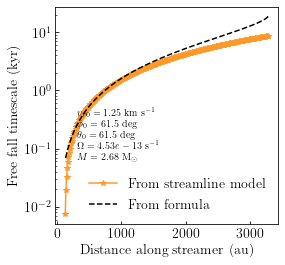

In [6]:
time_theory = t_freefall_acc(0 *u.au, dist_mean, r0, mass=Mstar)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(dist_mean, time_integral_path/1e3, marker='*', color='#fe9929', label='From streamline model')
ax.plot(dist_mean, time_theory.value/1e3, color='k', linestyle='dashed', label='From formula')
ax.set_xlabel('Distance along streamer (au)')
ax.set_ylabel('Free fall timescale (kyr)')
ax.legend(frameon=False)
ax.annotate(r'$M='+str(Mstar.value)+r'$ M$_{\odot}$', (0.1, 0.3),xycoords='axes fraction', size=10)
ax.annotate(r'$\Omega='+str(omega0.value)+r'$ s$^{-1}$', (0.1, 0.35),xycoords='axes fraction', size=10)
ax.annotate(r'$\theta_0='+str(theta0.value)+r'$ deg', (0.1, 0.4),xycoords='axes fraction', size=10)
ax.annotate(r'$\phi_0='+str(theta0.value)+r'$ deg', (0.1, 0.45),xycoords='axes fraction', size=10)
ax.annotate(r'$v_{r0}='+str(v_r0.value)+r'$ km s$^{-1}$', (0.1, 0.5),xycoords='axes fraction', size=10)
# fig.savefig('test_t_ff_streamline_vs_theory.pdf', dpi=300, bbox_inches='tight')
# ax.set_xlim([0,50])
# ax.set_ylim([0,0.5])
ax.set_yscale('log')

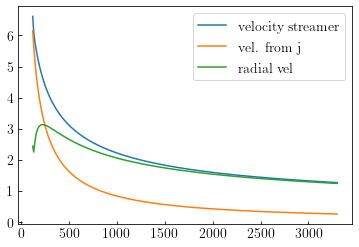

In [7]:
# This is to analyze the velocity components we have
vel_rota = (omega0 * r0**2 / dist_2d_streamer).to(u.km/u.s)
vel_rad = np.sqrt(vel_streamer**2 - vel_rota**2)

plt.plot(dist_streamer, vel_streamer, label='velocity streamer')
plt.plot(dist_streamer, vel_rota, label='vel. from j')
plt.plot(dist_streamer, vel_rad, label='radial vel')
plt.legend()
# plt.ylim([0, 1])

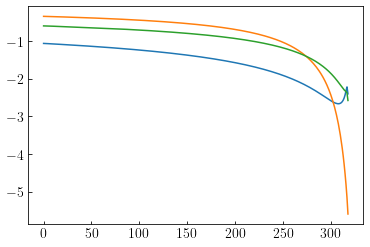

In [8]:
plt.plot(vx1)
plt.plot(vy1)
plt.plot(vz1)